# Problem 19: Application of a Groundwater Flow Model to a Water Supply Problem

# INTRODUCTION
_Groundwater flow models are often used in water resource evaluations to asses the long-term productivity of local or regional aquifers. This exercise presents an example of an application to a local system and involves calibration to an aquifer test and prediction using best estimates of aquifer properties. Of historical interest, this problem is adapted from one of the first applications of a digital model to a water resource problem (Pinder and Bredehoeft, 1968). The specific objective of their study was to assess whether a glaciofluviaI aquifer could provide an adequate water supply for a village in Nova Scotia._

# PROBLEM STATEMENT AND DATA
_The aquifer is located adjacent to the Musquodoboit River, l/4-mile northwest of the village of Musquodoboit Harbour, as shown in Figure 19.1. The aquifer is a glaciofluvial deposit consisting of coarse sand, gravel, cobbles, and boulders deposited in a typical U-shaped glacial valley cut into the slates and quartzites of the Meguma group and the granite intrusive of Devonian age. The contrast in permeability between the granitic and metamorphic rocks and the glaciofluvial valley fill is so great (approximately 106) that the bedrock is considered as_ [impermeable](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#i) _in the aquifer analysis. The aquifer, which is up to 62 feet thick, is extensively overlain by recent alluvial deposits of sand, silt and clay. The alluvial deposits are less permeable and act as confining beds. A_ [cross-section](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#c) _through the valley is given in Figure 19.2._

_A pumping test was conducted to evaluate the aquifer transmissivity and storage coefficient, and to estimate_ [recharge](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#r) _from the river. The test was run for 36 hours using a well discharging at 0.963 cubic feet per second (432 gallons per minute) and three observation wells (see inset of Figure 19.1 for locations). The test was discontinued when the water level in the pumping well became stable. Initial estimates of aquifer parameters were calculated using the Theis curve and the early segment of the drawdown curves for the observation wells. The results were somewhat variable, ranging from 1.15 ft2/s to 1.45 ft2/s. A_ [quasi-steady](https://github.com/jordw22/modflow_epa/blob/master/terms%20and%20definitions.md#q) _state formula for estimating transmissivity yielded results on the order of 0.3 ft2/s. Because of the close proximity of boundaries, the pumping test results are difficult to analyze using usual analytical methods._

_A listing of the data set for the MODFLOW model is provided on page 19-4. The aquifer is treated as confined, with transmissivity zones to account for thickness and facies changes. The ratio between zones of transmissivity (1,2, and 4) are given in the data set; absolute values of transmissivity are not given. A map of the transmissivity zones and model boundaries is given in Figure 19.3._

_A uniform value of storage coefficient is used in the analysis. The model is used to simulate drawdown, hence an initial head condition of 0.0 ft is used. Recharge is not specified because only drawdown is simulated. A river is simulated using the RIVER package. Its location is shown in Figure 19.4. Other pertinent data is given in Table 19.1._


## Part a) 
_Run the model with the data set provided. Plot the drawdowns at the observation wells and compare to the field data shown in Table 19.2 and Figure 19.5. Estimate better values of transmissivity and storage coefficient. Do not change location of transmissivity zones. Compare results and continue to adjust T and S until you are satisfied with the results._

In [31]:
#Import and modules/packages that we need to work with
%matplotlib inline
import os
import sys
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import flopy

In [32]:
#Store the values of each parameter into separate variables
inh = 0.0 #initial head
hk = .3*86400 #hydraulic conductivity ft^2/day
ss = 0.06 #storage coefficient
delr = 100 #grid spacing (uniform)
delc = delr
pr = -.963/7.48*86400 #pumping rate ft^3/day
perlen = 1.5 #stress period length in days
nstp = 10 #number of time steps
tsmult = 1.414 #time step multiplier
it_par = 5 # iteration parameters
mxiter = 50 #maximum number of iterations
accel_par = 1.0 #acceleration parameter
hclose = 0.001 #closure criterion (the head change criterion for convergence)
top = 0
botm = -1
nper = 1
laytyp = 0
ipakcb = 50

#grid 44 rows, 55 cols, 1 layer
nlay = 1 #number of layers
nrow = 44 #number of rows
ncol = 55 #number of columns

#riv package
rstage = 0.0 #river stage
rcond = 1728 #river conductance in ft^2/day
rbot = -10 #river bottom

#print to double check the math is done correctly
print(hk)
print(pr)

25920.0
-11123.422459893047


In [33]:
#Flopy objects
modelname = 'p19' #short for problem 19
exe_name = '../MF2005.1_12/bin/mf2005.exe'
model_ws = 'temp'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = model_ws)

#call in the discretization package
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

True


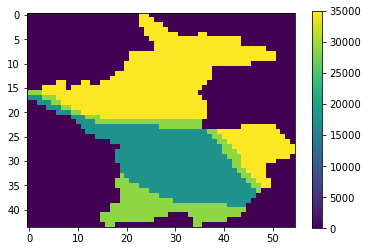

In [34]:
#call in the layer-propery flow (LPF)
#use the txt file provided in the data folder and configure it so that python can read it properly
fname='..\Data\p19_trans.txt'
print(os.path.isfile(fname))
with open(fname) as f:
    data = f.read().splitlines()
    
f.close()
#print(data)

#for each element in data change to int value and then reshape the boundaries of the list to (44, 55)
ibound = []
for s in data:
    for value in s.strip().split(' '):
        ibound.append(int(value))
ibound = np.array(ibound)
ibound = ibound.reshape((44, 55))
plt.imshow(ibound)
#save the values in hk as float
hk = np.empty((44, 55), dtype=np.float)
hk[:, :] = ibound[:, :]

#these change hk of each well (1, 2, and 3), we want to keep changing the modeled data until the drawdown matches the measured data (shown in fig 19.6)
hk1 = 35000.
hk2 = 29000.
hk4 = 18000.

#where hk = 1 there is a relative transmissivity of 1 (colored yellow)
hk = np.where(hk==1, hk1, hk)
#where hk = 2 there is a relative transmissivity of 2 (colored green)
hk = np.where(hk==2, hk2, hk)
#where hk = 4 there is a relative transmissivity of 4 (colored blue-green)
hk = np.where(hk==4, hk4, hk)
#where hk = 0 there is no active cells (color dark puple)
plt.imshow(hk)
plt.colorbar()

lpf = flopy.modflow.ModflowLpf(mf, hk=hk, ss=ss, laytyp=laytyp, ipakcb=ipakcb)

In [35]:
#call in the basic package
strt = 0.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 27, 31, pr], [0, 27, 31, pr], [0, 28, 34, pr], [0, 30, 31, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)

#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)

#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 'save budget']})

#call in the river package (RIV)
#create .csv file of the river data
riv_boundary = pd.read_csv('../Data/problem19_riv.csv')
#change the rcond from original value to 1728
riv_boundary.rcond = 1728
#subtract 1 so that the layer, row, and col match up with pythons rules
riv_boundary.layer -=1
riv_boundary.row -=1
riv_boundary.col -=1
print(riv_boundary.values)

riv_spd = {0: riv_boundary.values}

riv = flopy.modflow.ModflowRiv(mf, stress_period_data=riv_spd, ipakcb=ipakcb)

[[   0   17    0    0 1728  -10]
 [   0   17    1    0 1728  -10]
 [   0   18    2    0 1728  -10]
 [   0   18    3    0 1728  -10]
 [   0   19    4    0 1728  -10]
 [   0   19    5    0 1728  -10]
 [   0   19    6    0 1728  -10]
 [   0   20    7    0 1728  -10]
 [   0   20    8    0 1728  -10]
 [   0   21    9    0 1728  -10]
 [   0   21   10    0 1728  -10]
 [   0   21   11    0 1728  -10]
 [   0   22   12    0 1728  -10]
 [   0   22   13    0 1728  -10]
 [   0   23   14    0 1728  -10]
 [   0   23   15    0 1728  -10]
 [   0   23   16    0 1728  -10]
 [   0   23   17    0 1728  -10]
 [   0   24   18    0 1728  -10]
 [   0   24   19    0 1728  -10]
 [   0   24   20    0 1728  -10]
 [   0   24   21    0 1728  -10]
 [   0   25   22    0 1728  -10]
 [   0   25   23    0 1728  -10]
 [   0   26   24    0 1728  -10]
 [   0   26   25    0 1728  -10]
 [   0   27   26    0 1728  -10]
 [   0   27   27    0 1728  -10]
 [   0   27   28    0 1728  -10]
 [   0   27   29    0 1728  -10]
 [   0   2

In [36]:
# Write the MODFLOW model input files
mf.write_input()

# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following executable to run the model: ../MF2005.1_12/bin/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: p19.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2017/08/17  9:25:29

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8    Ground

In [37]:
import flopy.utils.binaryfile as bf

# Create the headfile object
fname = os.path.join(model_ws, 'p19.hds') #"os.path.join" joins together the modelname and the .hds file and stores it in fname
headobj = bf.HeadFile(fname) #create headobj and put values from fname (aka 'p1_pa.hds') inside it
times = headobj.get_times() #assign the headobj values to the variable "times"
print(times) #prints the time at each stress period

#print hydraulic head (Table 14.2)
idx = (0, 28, 31) #(nlay, nrow, ncol) *remember you have to subtract 1 from the original numbers for python - (1, 29, 32)*
ts = headobj.get_ts([idx])
print(ts)

[0.020063508, 0.048433311, 0.088548213, 0.14527068, 0.22547624, 0.33888692, 0.49924961, 0.72600245, 1.046631, 1.4999998]
[[ 0.02006351 -0.06342287]
 [ 0.04843331 -0.14257176]
 [ 0.08854821 -0.2211404 ]
 [ 0.14527068 -0.2955716 ]
 [ 0.22547624 -0.36549398]
 [ 0.33888692 -0.43092448]
 [ 0.49924961 -0.49189475]
 [ 0.72600245 -0.54853815]
 [ 1.04663098 -0.60124058]
 [ 1.49999976 -0.65091348]]


(0, 0.65091348)

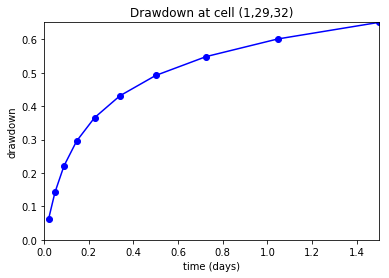

In [38]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 
plt.plot(ts[:, 0], 0-ts[:, 1], 'bo-') #(x, y, color/type of line)
plt.xlim(0, ts[:, 0].max())
plt.ylim(0, (0-ts[:, 1]).max())

(-0.65091348, -0.063422866)

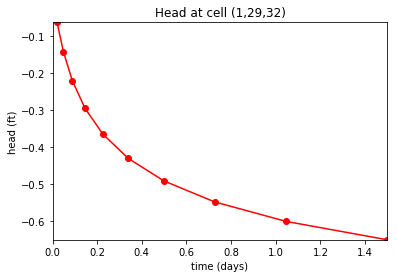

In [39]:
# Plot the head versus time
plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)
plt.title(ttl)
plt.xlabel('time (days)')
plt.ylabel('head (ft)')
plt.plot(ts[:, 0], ts[:, 1], 'ro-')
plt.xlim(0, ts[:, 0].max())
plt.ylim(ts[:, 1].min(), ts[:, 1].max())

## Figure 19.4
_Location of the river boundary condition, pumping well, and observation wells use in the numerical model._

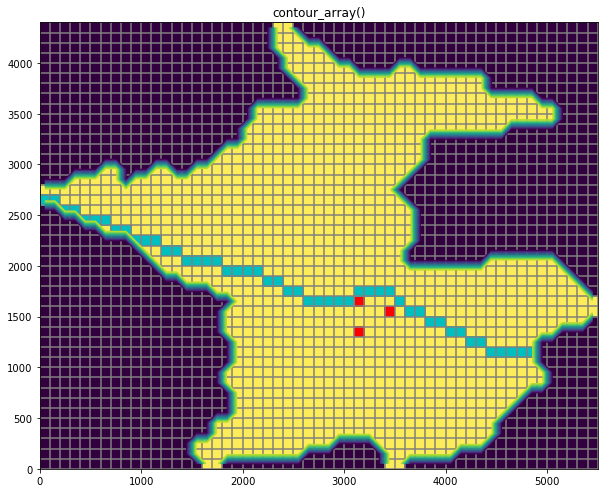

In [40]:
fname = os.path.join(modelname, 'p19_pa.cbc')
head = headobj.get_data(totim=times[-1])
levels = np.linspace(head.min(), head.max(), 10)

fig = plt.figure(figsize=(10, 10))

#plot_array
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('contour_array()')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(head, masked_values=[999.], alpha=0.5)
modelmap.plot_bc("WEL") #red squares on map
modelmap.plot_bc("RIV", color='c') #blue squares on map
linecollection = modelmap.plot_grid()
contour_set = modelmap.contour_array(head, masked_values=[999.], levels=levels)

In [41]:
#create different variables for each well so that you can plot them
table2 = pd.read_csv('../Data/table19.2.csv')
print(table2)

well1=table2.ix[0:, ['Time (min)', 'Observation Well 1']]
print(well1)

well2=table2.ix[0:, ['Time (min)', 'Observation Well 2']]
print(well2)

well3=table2.ix[0:, ['Time (min)', 'Observation Well 3']]
print(well3)

   Time (min)  Observation Well 1  Observation Well 2  Observation Well 3
0           1                0.17                0.04                0.00
1           4                0.26                0.12                0.01
2          10                0.33                0.16                0.02
3          40                0.48                0.22                0.08
4         100                0.57                0.29                0.14
5         400                0.79                0.51                0.30
6        1000                0.99                0.70                0.50
7        2000                1.19                0.86                0.68
8        3000                1.33                0.98                0.78
   Time (min)  Observation Well 1
0           1                0.17
1           4                0.26
2          10                0.33
3          40                0.48
4         100                0.57
5         400                0.79
6        1000         

## Measured Data: Original Data

In [42]:
# *remember you have to subtract 1 from the original numbers for python*
#well 1 (28, 32)
idx1 = (0, 27, 31) #(nlay, nrow, ncol)

#well 2 (29, 35)
idx2 = (0, 28, 34)

#well 3 (31, 32)
idx3 = (0, 30, 31)

ts = headobj.get_ts([idx1, idx2, idx3])
print(ts)
#prints out time, and the rate of drawdown at well 1, well 2, and well 3

[[ 0.02006351 -0.25966126 -0.13132407 -0.132429  ]
 [ 0.04843331 -0.3975251  -0.20603184 -0.20935917]
 [ 0.08854821 -0.48799458 -0.26325101 -0.26938531]
 [ 0.14527068 -0.56124097 -0.31795898 -0.3271814 ]
 [ 0.22547624 -0.62712097 -0.3735531  -0.38609004]
 [ 0.33888692 -0.68826467 -0.42949185 -0.44552872]
 [ 0.49924961 -0.74529701 -0.48451915 -0.50412196]
 [ 0.72600245 -0.79847521 -0.53762561 -0.56074625]
 [ 1.04663098 -0.84815598 -0.5883081  -0.61493367]
 [ 1.49999976 -0.89509666 -0.63685054 -0.66720659]]


## Model Data: Edited Data

In [43]:
#these are the original values, print them out to see what they are before we change them
well_data=np.array(table2)
print(well_data)

[[  1.00000000e+00   1.70000000e-01   4.00000000e-02   0.00000000e+00]
 [  4.00000000e+00   2.60000000e-01   1.20000000e-01   1.00000000e-02]
 [  1.00000000e+01   3.30000000e-01   1.60000000e-01   2.00000000e-02]
 [  4.00000000e+01   4.80000000e-01   2.20000000e-01   8.00000000e-02]
 [  1.00000000e+02   5.70000000e-01   2.90000000e-01   1.40000000e-01]
 [  4.00000000e+02   7.90000000e-01   5.10000000e-01   3.00000000e-01]
 [  1.00000000e+03   9.90000000e-01   7.00000000e-01   5.00000000e-01]
 [  2.00000000e+03   1.19000000e+00   8.60000000e-01   6.80000000e-01]
 [  3.00000000e+03   1.33000000e+00   9.80000000e-01   7.80000000e-01]]


In [44]:
#here we are making a copy of the original list and then dividing the first column 
#by 1440 to change minutes to days. Then print to see new values
well_data2=well_data.copy()
well_data2[:, 0]=well_data2[:, 0]/1440
print(well_data2)

[[  6.94444444e-04   1.70000000e-01   4.00000000e-02   0.00000000e+00]
 [  2.77777778e-03   2.60000000e-01   1.20000000e-01   1.00000000e-02]
 [  6.94444444e-03   3.30000000e-01   1.60000000e-01   2.00000000e-02]
 [  2.77777778e-02   4.80000000e-01   2.20000000e-01   8.00000000e-02]
 [  6.94444444e-02   5.70000000e-01   2.90000000e-01   1.40000000e-01]
 [  2.77777778e-01   7.90000000e-01   5.10000000e-01   3.00000000e-01]
 [  6.94444444e-01   9.90000000e-01   7.00000000e-01   5.00000000e-01]
 [  1.38888889e+00   1.19000000e+00   8.60000000e-01   6.80000000e-01]
 [  2.08333333e+00   1.33000000e+00   9.80000000e-01   7.80000000e-01]]


## Figure 19.6
_Comparison of modeled to observed drawdown (ft) data for the base case._

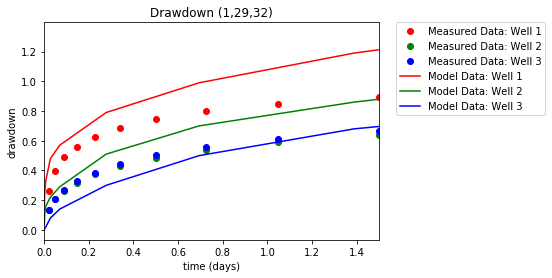

In [45]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx so that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 

plt.plot(ts[:, 0], 0-ts[:, 1], 'ro', label='Measured Data: Well 1') #well 1 measured data
plt.plot(ts[:, 0], 0-ts[:, 2], 'go', label='Measured Data: Well 2') #well 2 measured data
plt.plot(ts[:, 0], 0-ts[:, 3], 'bo', label='Measured Data: Well 3') #well 3 measured data
plt.plot(well_data2[:, 0], well_data2[:, 1], 'r-', label='Model Data: Well 1') #well 1 model data
plt.plot(well_data2[:, 0], well_data2[:, 2], 'g-', label='Model Data: Well 2') #well 2 model data
plt.plot(well_data2[:, 0], well_data2[:, 3], 'b-', label='Model Data: Well 3') #well 3 model data
plt.xlim(0, ts[:, 0].max())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #puts the legend to the right of the plot
#plt.ylim(0, (0-ts[:, 1:]).max())



In [46]:
print(levels)

[ -9.99989990e+02  -8.88880177e+02  -7.77770363e+02  -6.66660549e+02
  -5.55550736e+02  -4.44440922e+02  -3.33331109e+02  -2.22221295e+02
  -1.11111482e+02  -1.66796707e-03]


<a list of 248 text.Text objects>

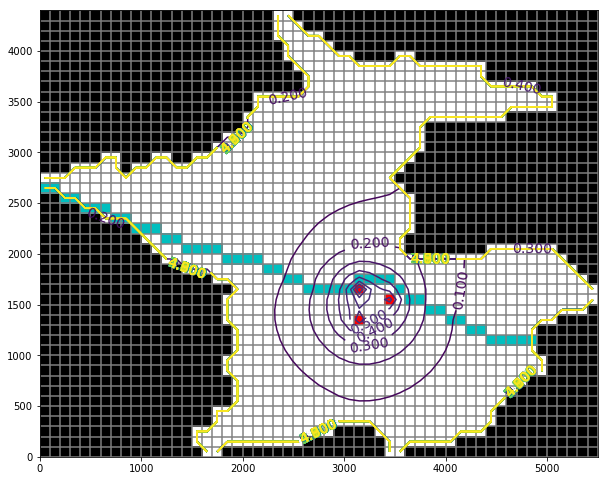

In [47]:
#shows the drawdown at each well 
fname = os.path.join(modelname, 'p19_pa.cbc')
head = 0-headobj.get_data(totim=times[-1])
levels = np.arange(0, 5, .1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf)
quadmesh = modelmap.plot_ibound()
modelmap.plot_bc("WEL")
modelmap.plot_bc("RIV", color='c')
linecollection = modelmap.plot_grid()
contour_set = modelmap.contour_array(head, masked_values=[-999.], levels=levels)
plt.clabel(contour_set, inline=1, fontsize=14)

In [48]:
fname = os.path.join(model_ws, 'p19_pa.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')
fff = cbb.get_data(text='FLOW FRONT FACE')

rflow = cbb.get_data(text='RIVER LEAKAGE') #create an array/for loop to get out first value of every step
#cbb.list_records()

#create new list
rlist=[]

#create for loop to store only the first value of each time step from rflow into rlist
for riv in rflow:
    rlist.append(riv['q'][0])
    
print(rlist)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.ModelMap(model=mf)


FileNotFoundError: [Errno 2] No such file or directory: 'temp\\p19_pa.cbc'

## Figure 19.7
_Comparison of modeled to observed drawdown in well 1 for the base case and for a 2-fold increase and one-half reduction in transmissivity._

In [49]:
#Flopy objects
modelname = 'p19' #short for problem 19
exe_name = '../MF2005.1_12/bin/mf2005.exe'
model_ws = 'temp'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = model_ws)

#call in the discretization package
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

fname='..\Data\p19_trans_double.txt'
print(os.path.isfile(fname))
with open(fname) as f:
    data = f.read().splitlines()
    
f.close()
#print(data)

ibound = []
for s in data:
    for value in s.strip().split(' '):
        ibound.append(int(value))
ibound = np.array(ibound)
ibound = ibound.reshape((44, 55))
plt.imshow(ibound)
hk = np.empty((44, 55), dtype=np.float)
hk[:, :] = ibound[:, :]

hk1 = 35000.
hk2 = 29000.
hk4 = 18000.

hk = np.where(hk==1, hk1, hk)
hk = np.where(hk==2, hk2, hk)
hk = np.where(hk==4, hk4, hk)
plt.imshow(hk)
plt.colorbar()

lpf = flopy.modflow.ModflowLpf(mf, hk=hk, ss=ss, laytyp=laytyp, ipakcb=ipakcb)

#call in the basic package
strt = 0.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 27, 31, pr], [0, 27, 31, pr], [0, 28, 34, pr], [0, 30, 31, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)

#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)

#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 'save budget']})

#call in the river package (RIV)
#figure out how to change conductance from the package
riv_boundary = pd.read_csv('../Data/problem19_riv.csv')
riv_boundary.rcond = 1728
riv_boundary.layer -=1
riv_boundary.row -=1
riv_boundary.col -=1
print(riv_boundary.values)

riv_spd = {0: riv_boundary.values}

riv = flopy.modflow.ModflowRiv(mf, stress_period_data=riv_spd, ipakcb=ipakcb)

# Write the MODFLOW model input files
mf.write_input()

# Run the MODFLOW model
success, buff = mf.run_model()

True


ValueError: total size of new array must be unchanged

In [22]:
#Flopy objects
modelname = 'p19' #short for problem 19
exe_name = '../MF2005.1_12/bin/mf2005.exe'
model_ws = 'temp'
mf = flopy.modflow.Modflow(modelname, exe_name=exe_name, model_ws = model_ws)

#call in the discretization package
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=top, botm=botm, nper=nper, perlen=perlen, 
                               nstp=nstp, tsmult=tsmult, steady=False)

fname='..\Data\p19_trans_half.txt'
print(os.path.isfile(fname))
with open(fname) as f:
    data = f.read().splitlines()
    
f.close()
#print(data)

ibound = []
for s in data:
    for value in s.strip().split(' '):
        ibound.append(int(value))
ibound = np.array(ibound)
ibound = ibound.reshape((44, 55))
plt.imshow(ibound)
hk = np.empty((44, 55), dtype=np.float)
hk[:, :] = ibound[:, :]

hk1 = 35000.
hk2 = 29000.
hk4 = 18000.

hk = np.where(hk==1, hk1, hk)
hk = np.where(hk==2, hk2, hk)
hk = np.where(hk==4, hk4, hk)
plt.imshow(hk)
plt.colorbar()

lpf = flopy.modflow.ModflowLpf(mf, hk=hk, ss=ss, laytyp=laytyp, ipakcb=ipakcb)

#call in the basic package
strt = 0.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

#call in the well package (WEL)
# Remember to use zero-based layer, row, column indices!
wel_sp1 = [[0, 27, 31, pr], [0, 27, 31, pr], [0, 28, 34, pr], [0, 30, 31, pr]]
wel_spd = {0: wel_sp1}
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)

#call in the preconditioned conjugate-gradient package (PCG) 
pcg = flopy.modflow.ModflowPcg(mf, mxiter=mxiter, hclose=hclose)

#call in the output control package (OC)
oc = flopy.modflow.ModflowOc(mf, stress_period_data={(0, 0): ['save head', 'print budget', 'save budget']})

#call in the river package (RIV)
#figure out how to change conductance from the package
riv_boundary = pd.read_csv('../Data/problem19_riv.csv')
riv_boundary.rcond = 1728
riv_boundary.layer -=1
riv_boundary.row -=1
riv_boundary.col -=1
print(riv_boundary.values)

riv_spd = {0: riv_boundary.values}

riv = flopy.modflow.ModflowRiv(mf, stress_period_data=riv_spd, ipakcb=ipakcb)

# Write the MODFLOW model input files
mf.write_input()

# Run the MODFLOW model
success, buff = mf.run_model()

True


ValueError: invalid literal for int() with base 10: '.5'

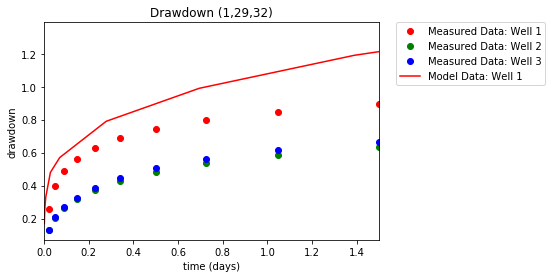

In [23]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 

plt.plot(ts[:, 0], 0-ts[:, 1], 'ro', label='Measured Data: Well 1') #well 1 measured data
plt.plot(ts[:, 0], 0-ts[:, 2], 'go', label='Measured Data: Well 2') #transmissivity times 2
plt.plot(ts[:, 0], 0-ts[:, 3], 'bo', label='Measured Data: Well 3') #transmissivity times .5
plt.plot(well_data2[:, 0], well_data2[:, 1], 'r-', label='Model Data: Well 1') #well 1 model data
#plt.plot(well_data2[:, 0], well_data2[:, 2], 'g-', label='Model Data: Well 2') #well 2 model data
#plt.plot(well_data2[:, 0], well_data2[:, 3], 'b-', label='Model Data: Well 3') #well 3 model data
plt.xlim(0, ts[:, 0].max())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #puts the legend to the right of the plot
#plt.ylim(0, (0-ts[:, 1:]).max())

## Table 19.3
_Modeled drawdown data for the base case. Transmissivities were 0.0685 ft^3/s, 0.137 ft^3/s, and 0.2740 ft^3/s and storage coefficient was 0.06._

|            |        | Drawdown (ft) |        |
|------------|--------|--------|--------|
| Time (min) | Well 1 | Well 2 | Well 3 |
| 4.98       | .033   | .00    | .00    |
| 12.0       | .09    | .01    | .00    |
| 22.0       | .17    | .03    | .01    |
| 36.1       | .27    | .07    | .02    |
| 56.0       | .37    | .12    | .04    |
| 84.1       | .47    | .18    | .07    |
| 124        | .57    | .25    | .11    |
| 180        | .67    | .33    | .17    |
| 260        | .77    | .41    | .23    |
| 372        | .86    | .50    | .30    |
| 531        | .95    | .59    | .38    |
| 456        | 1.04   | .68    | .46    |
| 1074       | 1.14   | .77    | .55    |
| 1524       | 1.23   | .86    | .64    |
| 2160       | 1.33   | .96    | .74    |

## Figure 19.8
_Comparison o fmodeled to observed drawdown in wells for the base case and for storage coefficients of .1 and .005._

In [24]:
ss1 = .2
ss2 = .002

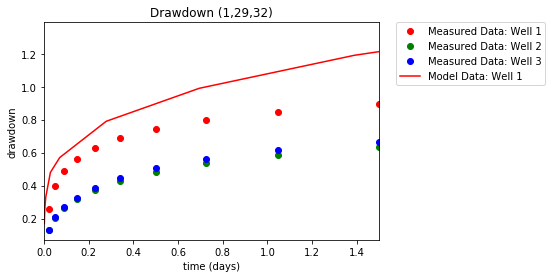

In [25]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 

plt.plot(ts[:, 0], 0-ts[:, 1], 'ro', label='Measured Data: Well 1') #well 1 measured data
plt.plot(ts[:, 0], 0-ts[:, 2], 'go', label='Measured Data: Well 2') #storage = 0.1
plt.plot(ts[:, 0], 0-ts[:, 3], 'bo', label='Measured Data: Well 3') #storage = 0.005
plt.plot(well_data2[:, 0], well_data2[:, 1], 'r-', label='Model Data: Well 1') #well 1 model data
#plt.plot(well_data2[:, 0], well_data2[:, 2], 'g-', label='Model Data: Well 2') #well 2 model data
#plt.plot(well_data2[:, 0], well_data2[:, 3], 'b-', label='Model Data: Well 3') #well 3 model data
plt.xlim(0, ts[:, 0].max())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #puts the legend to the right of the plot
#plt.ylim(0, (0-ts[:, 1:]).max())

## Figure 19.11
_Comparison of modeled to observed drawdown in well 1 fo rthe base case and for order of magnitude increase and decrease in river conductance._

In [26]:
#call in the river package (RIV)
#figure out how to change conductance from the package
riv_boundary = pd.read_csv('../Data/problem19_riv.csv')
riv_boundary.rcond1 = .2
riv_boundary.rcond2 = .002
riv_boundary.layer -=1
riv_boundary.row -=1
riv_boundary.col -=1
#print(riv_boundary.values)

riv_spd = {0: riv_boundary.values}

riv = flopy.modflow.ModflowRiv(mf, stress_period_data=riv_spd, ipakcb=ipakcb)

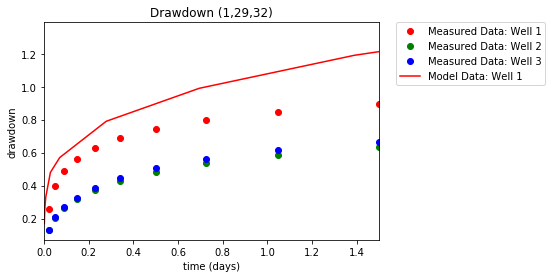

In [27]:
# Plot the drawdown versus time
plt.subplot(1, 1, 1)
ttl = 'Drawdown ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1) #we are adding 1 to each part of idx to that it prints out the real values and not the code values
plt.title(ttl) #prints/plots title
plt.xlabel('time (days)') #labels the x-axis
plt.ylabel('drawdown') #labels the y-axis
#here we do "0-ts..." in order to show the drawdown of 

plt.plot(ts[:, 0], 0-ts[:, 1], 'ro', label='Measured Data: Well 1') #well 1 measured data
plt.plot(ts[:, 0], 0-ts[:, 2], 'go', label='Measured Data: Well 2') #river conductance = 0.2
plt.plot(ts[:, 0], 0-ts[:, 3], 'bo', label='Measured Data: Well 3') #river conductance = 0.002
plt.plot(well_data2[:, 0], well_data2[:, 1], 'r-', label='Model Data: Well 1') #well 1 model data
#plt.plot(well_data2[:, 0], well_data2[:, 2], 'g-', label='Model Data: Well 2') #well 2 model data
#plt.plot(well_data2[:, 0], well_data2[:, 3], 'b-', label='Model Data: Well 3') #well 3 model data
plt.xlim(0, ts[:, 0].max())
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #puts the legend to the right of the plot
#plt.ylim(0, (0-ts[:, 1:]).max())

## Table 19.4
_Drawdown (ft) versus time in observation well 1 for variations in transmissivity, storage coefficient, and river leakance._

|            |           |                |      | Drawdown (ft)       |       |                |       |
|------------|-----------|----------------|------|---------------------|-------|----------------|-------|
|            |           | Transmissivity |      | Storage Coefficient |       | River Leakance |       |
| Time (min) | Base Case | 2X             | 1/2X | 0.1                 | 0.005 | 0.2            | 0.002 |
| 4.98       | .03       | .04            | .02  | .01                 | .33   | .03            | .03   |
| 2.0        | .09       | .09            | .07  | .05                 | .57   | .09            | .09   |
| 22.0       | .17       | .15            | .16  | .10                 | .75   | .17            | .17   |
| 36.1       | .27       | .21            | .28  | .17                 | .88   | .26            | .27   |
| 56.0       | .37       | .27            | .44  | .26                 | 1.00  | .36            | .37   |
| 85.1       | .47       | .33            | .61  | .35                 | 1.11  | .45            | .48   |
| 124        | .57       | .38            | .79  | .44                 | 1.22  | .53            | .58   |
| 180        | .67       | .43            | .98  | .54                 | 1.33  | .60            | .68   |
| 260        | .77       | .48            | 1.16 | .63                 | 1.44  | .66            | .78   |
| 372        | .86       | .53            | 1.34 | .73                 | 1.55  | .70            | .88   |
| 531        | .95       | .59            | 1.51 | .82                 | 1.67  | .74            | .99   |
| 756        | 1.04      | .64            | 1.67 | .91                 | 1.80  | .78            | 1.10  |
| 1074       | 1.14      | .70            | 1.83 | 1.00                | 1.93  | .80            | 1.21  |
| 1524       | 1.23      | .76            | 1.99 | 1.09                | 2.06  | .82            | 1.33  |
| 2160       | 1.33      | .83            | 2.14 | 1.19                | 2.18  | .84            | 1.47  |

# DISCUSSION OF RESULTS

_This problem illustrates one type of calibration or history match. In this case aquifer parameters were adjusted in the model to match observed drawdown from a short-term transient event. Within the constraints of the problem statement, adjustments to transmissivity and storage coefficient resulted in the match shown in Figure 19.6. The match is good in late time, but not in early time. Adjustments to transmissivity change the magnitude of drawdown at a given time (Figure 19.7) while adjustments to storage coefficient changes the shape of the curve before equilibrium is attained (Figure 19.8). The poor match in early time appears to be the result of the storage properties. A decrease in storage coefficient would have the desired effect of increasing drawdown in early time, but would also increase it beyond observed values in later time. To circumvent this dilemma, Pinder and Bredehoeft (1968) introduced a time-dependent storage coefficient to approximate drainage of the aquifer system. The initial value of storage coefficient of 0.003 was allowed to increase linearly with time to a maximum of 0.06 after 10 minutes of pumping. This is not a standard application and requires either numerous restart simulations or a code modification. Another approximation is to specify a partially convertible aquifer (LAYCON=2) in the BCF package. A closer match (see Figure 19.10) to early time behavior is obtained with a primary storage factor (SF1 ) of 0.003, a secondary storage factor (SF2) of 0.06, and an aquifer top elevation (TOP) of-0.1 ft. Both the time-dependent storage adjustment by Pinder and Bredehoeft and the current magnitude-dependent adjustment are fairly crude approximations to what appears to be a delayed yield effect._

_The slightly imperfect match to late-time data for the MODFLOW model base case is the result of using Finder and Bredehoeft’s (1968) late-time storage coefficient without regard to the early-time factor that they used. As was illustrated in Figure 19.8, a higher constant value of storage coefficient (O. 1 ) results in a better late-time match._

_River leakage is important because steady-state flow conditions depend on the quantity of water entering the system through the river bed. When the system is at steady state, the pumpage will be balanced by river recharge. The system is close to steady state after 125 days (timestep 24) of pumping as maybe seen from the storage contribution (0.0055 ft3/s) relative to the river leakage (0.9574 ft3/s) in the mass balance. The model is mom sensitive to river conductance in late time than in early time. This is shown in Figure 19.11. The results of all sensitivity simulations for well 1 are given in Table 19.4.
Several potential weaknesses exist in this calibration procedure. The aquifer test provides confidence in parameters close to the pumping well, but less confidence in the characterization distant from the well. The variability in thickness and facies is apparent in the cross-section of Figure 19.2, and yet the representation is fairly simple. Because no wells exist to monitor the effect on the other side of the river, it is difficult to have complete confidence in the characterization of the aquifer/river interaction. This is important because the degree of connection will ultimately govern the productivity of the aquifer. Finally, the need to introduce the delayed-yield effect is not satisfying. Although it is likely that delayed yield is occurring, the representation in the model is very crude. The transient calibration procedure performed here is well suited for a localized aquifer system where the ultimate source of water is close to the pumping well. Additional confidence in the calibration could be obtained through a steady-state history match to water levels through the aquifer._

_The prediction indicates that the aquifer can supply the village with the desired quantity of water with minimal drawdown in the aquifer. The long term drawdown was shown in Figure 19.9. The results obtained by Pinder and Bredehoeft (1968) and Pinder and Frind (1972) are similar to the current results. This good comparison provides confidence in the applicability of MODFLOW to a field problem._
